**Задачи:**

Построить когорты по датам установки в разбивках по платформам, источникам и использованию промокода (да/нет)  
Посчитать средний чек, LTV (как по доходу, так и по прибыли), ROI (для источников, у которых есть расходы) когорт  
Построить месячные Retention  

и ответить на вопросы:  
Влияет ли использование промокода на retention и LTV?  
Как скоро пользователь, пришедший с платного трафика, окупается?  
Какой источник обладает наибольшей окупаемостью и какой стоит масштабировать?

## Путеводитель:
* [Предобработка данных](#first-bullet)
* [Подготовка данных для когортного анализа](#second-bullet)
* [Ключевые параметры анализа, обоснование](#third-bullet)
* [Построение когорт: объявление функций](#forth-bullet)
* [Когорты по датам установки и использованию промокода](#fifth-bullet)
* [Как скоро окупается пользователь?](#sixth-bullet)
* [Метрики по источникам утсановки](#seventh-bullet)

In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Предобработка данных <a class="anchor" id="first-bullet"></a>

In [12]:
# функция, характеризующая датафрейм
def df_about(df):
    """
    Функция возращает информацию о количестве строк, пропущенных значениях, их типах
    """    
    print(f'Всего строк:{df.shape[0]}')
    print(f'\nПропущенных значений: \n{df.isna().sum()}')
    print(f'\nТипы значений: \n{df.dtypes}')
    display(df.head())

In [13]:
af_purchase_events = pd.read_csv('af_purchase_events.csv', index_col=0)
df_about(af_purchase_events)

"""install_date - дата установки     
event_date - дата совершения события покупки
media_source    - источник установки
appsflyer_id - уникальный id пользователя
order_id - id заказа
platform - платформа"""


Всего строк:410866

Пропущенных значений: 
install_date        0
event_date          0
media_source    17553
appsflyer_id        0
order_id            0
platform            0
dtype: int64

Типы значений: 
install_date    object
event_date      object
media_source    object
appsflyer_id    object
order_id         int64
platform        object
dtype: object


,install_date,event_date,media_source,appsflyer_id,order_id,platform
0,2022-02-22,2022-04-05,NaN,1601193708327-2124074,116500114,ios
1,2022-02-22,2022-02-22,NaN,1601193708327-2124074,106005063,ios
2,2022-06-28,2022-06-28,NaN,1605772406223-1111986,132025104,ios
3,2022-03-03,2022-03-03,NaN,1606031514956-3156680,107089580,ios
4,2022-02-15,2022-02-16,NaN,1608405163318-4242987,105331680,ios


'install_date - дата установки     \nevent_date - дата совершения события покупки\nmedia_source    - источник установки\nappsflyer_id - уникальный id пользователя\norder_id - id заказа\nplatform - платформа'

Необходимо изменить тип данных для столбцов с датами. 
Проверим данные по датам - дата заказа не должна предшествовать дате установки. Если такие строки есть, удалим их из датасета. 
Проверим данные на дубликаты по номеру заказа (они могут быть, так как в этом датасете отражается информация по созданным и не всегда завершенным заказам). Если такие есть - проверим еще раз после соединения.

In [14]:
af_purchase_events = af_purchase_events.astype({'install_date': 'datetime64', 'event_date': 'datetime64'})

print(f'Событий, произошедших раньше установки: {af_purchase_events.query("install_date > event_date").install_date.count()}')
print(f'Дубликатов по номеру заказа: {af_purchase_events.duplicated("order_id").sum()}')

Событий, произошедших раньше установки: 40
Дубликатов по номеру заказа: 37


In [15]:
af_purchase_events = af_purchase_events.query("install_date <= event_date")

In [16]:
af_purchase_events.describe(include='all')

<ipython-input-16-ac53c08b4782>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  af_purchase_events.describe(include='all')
<ipython-input-16-ac53c08b4782>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  af_purchase_events.describe(include='all')


,install_date,event_date,media_source,appsflyer_id,order_id,platform
count,410826,410826,393275,410826,4.108260e+05,410826
unique,187,187,234,144088,NaN,2
top,2022-03-12 00:00:00,2022-03-30 00:00:00,organic,1641056005723-7791151515678663479,NaN,android
freq,5193,4149,167510,234,NaN,239379
first,2022-01-01 00:00:00,2022-01-01 00:00:00,NaN,NaN,NaN,NaN
last,2022-07-06 00:00:00,2022-07-06 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.169079e+08,NaN
std,NaN,NaN,NaN,NaN,9.328299e+06,NaN
min,NaN,NaN,NaN,NaN,9.257990e+07,NaN
25%,NaN,NaN,NaN,NaN,1.077426e+08,NaN


In [19]:
# данные по заказам
crm_data = pd.read_csv('crm_data.csv')

"""
orderID - id заказа
orderDate - дата заказа
orderNumber    - порядковый номер заказа пользователя
Region - регион заказа    
Sum - сумма заказа
promoId - id промокода
"""

'\norderID - id заказа\norderDate - дата заказа\norderNumber    - порядковый номер заказа пользователя\nRegion - регион заказа    \nSum - сумма заказа\npromoId - id промокода\n'

In [20]:
crm_data.Sum = crm_data.Sum.apply(lambda x: x * np.random.random() * 2).round(2)
crm_data = crm_data.drop(columns=['Region'])
crm_data

,Unnamed: 0,orderID,orderDate,orderNumber,Sum,promoId
0,0,104153949,2022-02-03,27.0,1082.84,NaN
1,1,104153611,2022-02-03,7.0,2009.12,NaN
2,2,104153075,2022-02-03,52.0,2469.56,NaN
3,3,104152561,2022-02-03,33.0,4462.46,NaN
4,4,104152169,2022-02-03,17.0,4154.36,NaN
...,...,...,...,...,...,...
1895215,1895215,101561398,2022-01-17,60.0,1133.80,6473; 7024
1895216,1895216,102070498,2022-01-17,139.0,568.52,6473; 7026
1895217,1895217,102070859,2022-01-17,87.0,2616.80,414; 3898; 6473
1895218,1895218,102377896,2022-01-17,1.0,2943.26,2740; 5302; 5811


Переименуем колонки для удобства соединения таблиц и единообразия.  
Пропуски в графе promo_id логичны, в графе порядкового номера заказа - пока оставим (если после соединения данных пропуски сохранятся, можно будет заполнить данные).  
На всякий случай проверим номера заказов на уникальность, если есть дубликаты - проверим еще раз после соединения  данных.

In [21]:
crm_data.drop(columns=['Unnamed: 0'], inplace=True)
crm_data.orderDate = pd.to_datetime(crm_data.orderDate)
crm_data.rename(columns={'orderID': 'order_id',
                         'orderDate': 'event_date',
                         'orderNumber': 'order_number',
                         'Sum': 'sum',
                         'promoId': 'promo_id',
                         }, inplace=True)

In [22]:
crm_data[crm_data.order_id.duplicated()]

,order_id,event_date,order_number,sum,promo_id
1583861,132916834,2022-07-03,125.0,6345.63,6473


In [23]:
# посмотрим на дубликаты 
crm_data[crm_data.order_id == 132916834]

,order_id,event_date,order_number,sum,promo_id
1191016,132916834,2022-07-03,124.0,2843.55,6473
1583861,132916834,2022-07-03,125.0,6345.63,6473


In [24]:
crm_data.describe(include='all')

<ipython-input-24-9f32d85d7326>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  crm_data.describe(include='all')


,order_id,event_date,order_number,sum,promo_id
count,1.895220e+06,1895220,1.895170e+06,1.895220e+06,957956
unique,NaN,186,NaN,NaN,4969
top,NaN,2022-01-30 00:00:00,NaN,NaN,6473
freq,NaN,16431,NaN,NaN,411565
first,NaN,2022-01-01 00:00:00,NaN,NaN,NaN
last,NaN,2022-07-05 00:00:00,NaN,NaN,NaN
mean,1.129772e+08,NaN,3.644237e+01,4.443819e+03,NaN
std,9.911906e+06,NaN,4.529574e+01,4.424235e+03,NaN
min,8.635579e+07,NaN,1.000000e+00,0.000000e+00,NaN
25%,1.044560e+08,NaN,6.000000e+00,1.579210e+03,NaN


In [25]:
# данные по расходам
cost_data = pd.read_csv('cost_data.csv', index_col=0)
df_about(cost_data)

"""
date - дата расходов
platform - платформа
media_source    - источник
cost - расходы
"""

Всего строк:6649

Пропущенных значений: 
date            0
platform        0
media_source    0
cost            0
dtype: int64

Типы значений: 
date             object
platform         object
media_source     object
cost            float64
dtype: object


,date,platform,media_source,cost
0,2022-05-17,android,vk_int,204.775000
1,2022-05-07,android,vk_int,1336.566667
2,2022-04-12,android,vk_int,1500.825000
3,2022-06-10,android,vk_int,5028.433333
4,2022-05-29,android,vk_int,29.083333


'\ndate - дата расходов\nplatform - платформа\nmedia_source    - источник\ncost - расходы\n'

In [26]:
# изменим тип данных для даты, переименуем в install_date
cost_data = cost_data.astype({'date': 'datetime64'}) \
                    .rename(columns={'date': 'install_date'})

## Подготовка данных для когортного анализа <a class="anchor" id="second-bullet"></a>

Соединяем датасеты af_purchase_events и sort_value по дате и номеру заказа (получим данные по оплаченным заказам c 01.01.2022 по 05.07.2022 от пользователей, установивших (впервые открывших) приложение в 2022 году

In [27]:
cohort_data = af_purchase_events.merge(crm_data, how='inner', on=['event_date', 'order_id'])

In [28]:
df_about(cohort_data)

Всего строк:341810

Пропущенных значений: 
install_date         0
event_date           0
media_source     13701
appsflyer_id         0
order_id             0
platform             0
order_number        10
sum                  0
promo_id        151452
dtype: int64

Типы значений: 
install_date    datetime64[ns]
event_date      datetime64[ns]
media_source            object
appsflyer_id            object
order_id                 int64
platform                object
order_number           float64
sum                    float64
promo_id                object
dtype: object


,install_date,event_date,media_source,appsflyer_id,order_id,platform,order_number,sum,promo_id
0,2022-02-22,2022-04-05,NaN,1601193708327-2124074,116500114,ios,2.0,4447.11,NaN
1,2022-02-22,2022-02-22,NaN,1601193708327-2124074,106005063,ios,1.0,1556.95,2740
2,2022-06-28,2022-06-28,NaN,1605772406223-1111986,132025104,ios,1.0,2506.29,2740; 7634
3,2022-03-03,2022-03-03,NaN,1606031514956-3156680,107089580,ios,1.0,28668.38,2740; 5811
4,2022-03-15,2022-04-09,NaN,1610906797000-7124321,117281442,ios,1.0,5344.21,2740; 7525


In [29]:
print(f'Событий, произошедших раньше установки: {cohort_data.query("install_date > event_date").install_date.count()}')
print(f'Дубликатов по номеру заказа: {cohort_data.duplicated("order_id").sum()}')

Событий, произошедших раньше установки: 0
Дубликатов по номеру заказа: 0


Добавим в таблицу данные для сегментирования использованию промокода: отметим пользователей, сделавших первый заказ в приложении с использованием промокода и посчитаем сумму расходов на промокоды для каждого заказа

In [30]:
# проверим, не были ли использованы оплачиваемые промокоды одновременно (не были)

def count_promo_matches(row):
    """Функция возвращает количество использованных заданных промокодов"""
    
    promos = map(str, [7525, 7641, 7937, 5403, 7061])
    count = 0
    for promo in promos:
        pattern = rf"\b{promo}\b"
        if re.search(pattern, str(row)):
            count += 1
    return count


(cohort_data['promo_id'].apply(count_promo_matches) > 1).sum()

0

In [31]:
def cost_of_promo(row):
    """
    Функция возвращает размер выплаты блогерам за использование промокода при покупке
    """
    if re.search(r'\b7525\b', str(row['promo_id'])) and row['sum'] >= 2000:
        return 800
    elif ((re.search(r'\b7641\b', str(row['promo_id'])) and row['sum'] >= 1000)
          or (re.search(r'\b7937\b', str(row['promo_id'])) and row['sum'] >= 3000)
          or (re.search(r'\b5403\b', str(row['promo_id'])) and row['sum'] >= 1500)
        ):
        return 600
    elif (re.search(r'\b7061\b', str(row['promo_id'])) and row['sum'] >= 3000 and row.order_number == 1):
        return 200
    else:
        return 0

Отметим пользователей, совершивших первые заказы через приложение с промокодом (для целей сегментирования по использованию промокодов)

In [32]:
first_inapp_order_data = cohort_data.groupby('appsflyer_id', as_index=False) \
                                    .agg({'order_id': 'min'}) \
                                    .merge(
                                        cohort_data[cohort_data.promo_id.notna()][['appsflyer_id', 'order_id', 'promo_id']],
                                        how='inner'
                                        ) \
                                    .assign(attracted_by_promo=True)

first_inapp_order_data.head()

,appsflyer_id,order_id,promo_id,attracted_by_promo
0,1590990370330-9831843,126429862,2740,True
1,1591082800318-2450224,131535924,2740; 7525,True
2,1591452643927-3426096,115341999,2740; 7634,True
3,1591901749098-2192148,107527937,2740,True
4,1593531207000-9186608,118664271,2740,True


Рассчитаем расходы на медиаисточники на каждый заказ (данные из cost_data приведем к кол-ву соответствующих заказов)

In [33]:
media_costs_data = cohort_data.groupby(['install_date', 'platform', 'media_source'], as_index=False) \
            .agg({'order_id': pd.Series.nunique}) \
            .merge(cost_data, on=['install_date', 'platform', 'media_source'])

media_costs_data['media_costs_per_order'] = media_costs_data.cost / media_costs_data.order_id
media_costs_data

,install_date,platform,media_source,order_id,cost,media_costs_per_order
0,2022-01-01,android,facebook and tiktok,310,30465.320000,98.275226
1,2022-01-01,android,googleadwords_int,33,8647.570000,262.047576
2,2022-01-01,android,mobisummer_int,1,1200.000000,1200.000000
3,2022-01-01,android,wingsapps_int,6,3600.000000,600.000000
4,2022-01-01,android,yandexdirect_int,6,24426.258333,4071.043056
...,...,...,...,...,...,...
5193,2022-07-05,ios,practicads_int,3,2400.000000,800.000000
5194,2022-07-05,ios,pubmint_int,1,2000.000000,2000.000000
5195,2022-07-05,ios,targetmedia_int,1,2000.000000,2000.000000
5196,2022-07-05,ios,z2adigital_int,1,4800.000000,4800.000000


In [34]:
# столбец с данными по расходам на промокоды
cohort_data['promo_costs'] = cohort_data.apply(cost_of_promo, axis=1)

In [35]:
# итоговая таблица с данными по месяцу установки, использованию промокода при установке,расходам на доставку,
# себестоимости и расходам на медиаисточник (оставим только источники с данными по расходам)
profit_margin = 0.35
cohort_data = cohort_data \
                    .merge(first_inapp_order_data[['appsflyer_id', 'attracted_by_promo']], how='left', on='appsflyer_id') \
                    .merge(media_costs_data[['install_date', 'platform', 'media_source', 'media_costs_per_order']],
                          on=['install_date', 'platform', 'media_source'], how='inner')

cohort_data = cohort_data.assign(install_month=cohort_data.install_date.dt.month,
                            diff_months=cohort_data.event_date.dt.month - cohort_data.install_date.dt.month,
                            delivery_costs=lambda x: (x['sum'] >= 3000) * 1000,
                            var_costs=cohort_data['sum'] * (1 - profit_margin)
                           )
cohort_data.attracted_by_promo = cohort_data.attracted_by_promo.fillna(False)

In [36]:
cohort_data.head()

,install_date,event_date,media_source,appsflyer_id,order_id,platform,order_number,sum,promo_id,promo_costs,attracted_by_promo,media_costs_per_order,install_month,diff_months,delivery_costs,var_costs
0,2022-06-26,2022-07-01,vk_int,1656231571111-68559245049484901,132588367,android,9.0,298.68,NaN,0,False,350.745833,6,1,0,194.1420
1,2022-06-26,2022-07-01,vk_int,1656231571111-68559245049484901,131735913,android,8.0,1732.30,NaN,0,False,350.745833,6,1,0,1125.9950
2,2022-05-23,2022-05-23,vk_int,1653320885762-254961863411328768,125168414,android,22.0,4288.00,NaN,0,False,18.666667,5,0,1000,2787.2000
3,2022-05-29,2022-05-29,vk_int,1653850734085-870619777307432598,126280965,android,2.0,823.23,NaN,0,False,14.541667,5,0,0,535.0995
4,2022-05-29,2022-05-29,vk_int,1653848477961-8989871255208579135,126280460,android,52.0,934.19,NaN,0,False,14.541667,5,0,0,607.2235


Для целей оценки эффективности медиа источников можно отфильтровать источники, которые перестали по тем или иным причинам приводить пользователей (некоторые стали недоступны с марта 2022 года, некоторые, возможно, больше не используются). Поэтому для когорт по источникам возьмем источники, последняя дата установки для которых - не ранее 01.07.2022./

<AxesSubplot:>

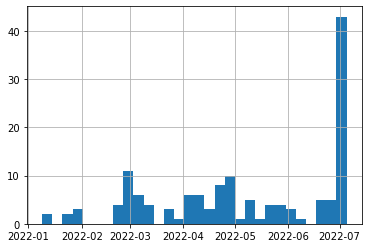

In [37]:
media_sources_data = cohort_data \
                         .groupby('media_source', as_index=False) \
                         .agg({'install_date': 'max'})
media_sources_data.install_date.hist(bins=30)

In [38]:
media_sources_data = media_sources_data[media_sources_data.install_date >= '2022-06-01']
sources = media_sources_data.media_source.to_list()

In [39]:
cohort_data_spec_sources = cohort_data.query("media_source in @sources")

## Ключевые параметры анализа <a class="anchor" id="third-bullet"></a>
**Признак формирования когорты** — дата установки приложения (пользователи, установившие приложение в июле - слишком маленькая когорта и сравнивать ее с остальными было бы неправильно)  
**Размер когорты** — месяц (обоснование для выбора:  
    - для доставки продуктов не выражена сезонность,  
    - большинство пользователей делают заказы нечасто (покажем это ниже),  
    - возможна зависимость показателей от дня недели (в выходные возрастает активновть пользователей, покажем это ниже), поэтому когорты по дням брать нецелесообразно  
**Временной интервал** — с 01.01.2022 по 05.07.2022 (данные за первые пять дней июля непоказательны для сравнения с целыми месяцами в выбранных условиях, для целей оценки удержания их можно использовать)   
**Ключевой показатель** — оцениваем месячные retention rate, а также средний чек, LTV по доходу и прибыли, ROI, PP для маркетинговых затрат на медиаисточники.

In [40]:
cohort_data = cohort_data[cohort_data.install_date <= '2022-06-30']
cohort_data_spec_sources = cohort_data_spec_sources[cohort_data_spec_sources.install_date <= '2022-06-30']

In [41]:
# посмотрим на показатели по дням недели

metrics_by_weekday = cohort_data.assign(weekday=cohort_data.install_date.dt.weekday)
metrics_by_weekday = metrics_by_weekday.groupby('weekday', as_index=False) \
        .agg({"sum": 'mean', 'appsflyer_id': pd.Series.nunique, 'order_id': 'count'}) \
        .rename(columns={'sum': 'AOV', 'appsflyer_id': 'users', 'order_id': 'orders'})
metrics_by_weekday

,weekday,AOV,users,orders
0,0,3968.178439,5001,12868
1,1,3874.483076,4970,12504
2,2,3924.748095,5404,13999
3,3,3955.875716,5663,15024
4,4,3925.850191,5268,13882
5,5,4040.500012,5979,16393
6,6,3923.800160,5823,15906


<AxesSubplot:xlabel='weekday', ylabel='AOV'>

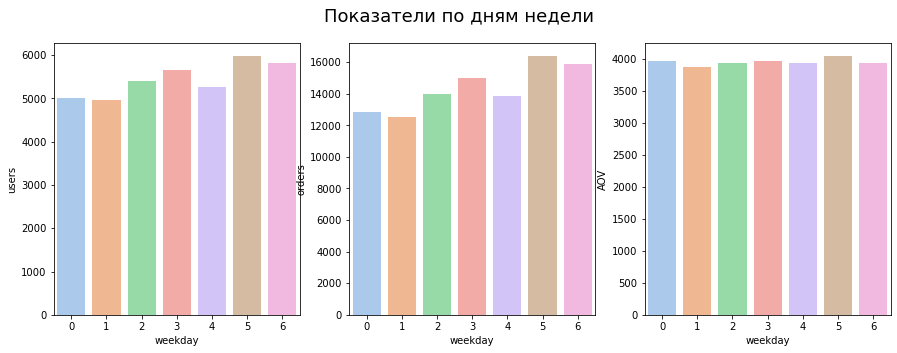

In [42]:
sns.set_palette("pastel")
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Показатели по дням недели', fontsize=18)

sns.barplot(data=metrics_by_weekday, x='weekday', y='users', ax=ax1)
sns.barplot(data=metrics_by_weekday, x='weekday', y='orders', ax=ax2)
sns.barplot(data=metrics_by_weekday, x='weekday', y='AOV', ax=ax3)

In [43]:
# посмотрим на данные по пользователям (кол-ву заказов и кол-ву уникальных дат заказов)
data_by_user = cohort_data.groupby('appsflyer_id') \
                                .agg({'event_date': ['min', 'max', pd.Series.nunique], 'order_id': 'count'})

In [44]:
col_list = []
for i in range(len(data_by_user.columns)):
    col_list.append(' '.join(list(data_by_user.columns[i])))
data_by_user.columns = col_list

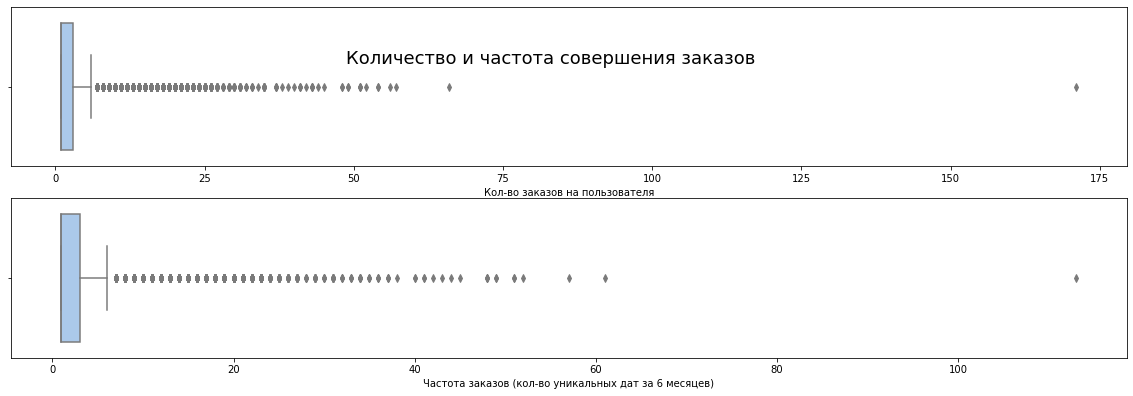

In [45]:
sns.set_palette("pastel")
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 5))
fig.suptitle('Количество и частота совершения заказов', fontsize=18)

sns.boxplot(data = data_by_user, x = 'order_id count', ax=ax1)
ax1.set(xlabel='Кол-во заказов на пользователя', ylabel='', title='')

sns.boxplot(data = data_by_user, x = 'event_date nunique', ax=ax2)
ax2.set(xlabel='Частота заказов (кол-во уникальных дат за 6 месяцев)', ylabel='', title='')

plt.subplots_adjust(top=1.1)

Медианные значения - 1 при средних 2,6, 75% пользователей сделали не больше 3 заказов, хотя есть и пользователи, которые делают заказы достаточно часто.
Отфильтруем тех, кто сделал только 1 заказ: получим медианное значение 3 при средних 4,6-4,7 заказа за 6 месяцев

In [46]:
data_by_user[data_by_user['order_id count'] > 1].describe()

,event_date nunique,order_id count
count,17078.000000,17078.000000
mean,4.560604,4.657805
std,4.378066,4.616094
min,1.000000,2.000000
25%,2.000000,2.000000
50%,3.000000,3.000000
75%,5.000000,5.000000
max,113.000000,171.000000


## Построение когорт: объявление функций <a class="anchor" id="forth-bullet"></a>

In [47]:
def cohorts_AOV_PP(df,
                  criteria): # критерии построения когорт (колонки)
    """Функция вовзращает таблицу, сгруппированную по колонкам criteria 
    и с данными по среднему чеку и PP (для медиаисточников)
    """
    
    # группируем по критериям и рассчитываем совокупные затраты, себестоимость, выручку, количество заказов и пользователей
    cohorts = df.groupby(criteria, as_index=False) \
                .agg({'sum': 'sum', 
                      'order_id': 'count',
                      'appsflyer_id': pd.Series.nunique,
                      'delivery_costs': 'sum',
                      'promo_costs': 'sum',
                      'var_costs': 'sum',
                      'media_costs_per_order': 'sum'
                     }) \
                .rename(columns={'sum': 'total_revenue',
                                 'order_id': 'orders',
                                 'appsflyer_id': 'users',
                                 'promo_costs': 'total_promo_costs',
                                 'delivery_costs': 'total_delivery_costs',
                                 'var_costs': 'total_var_costs',
                                 'media_costs_per_order': 'total_media_costs'
                                }
                       )
    
    cohorts['total_costs'] = (cohorts.total_var_costs + cohorts.total_delivery_costs
                            + cohorts.total_promo_costs + cohorts.total_media_costs)
        
    def name_cohorts(row):
        """Функция для формирования столбца с именем когорты"""
        cohort_name = ''
        for col in range(len(criteria)):
            cohort_name += ('_' + str(row[criteria[col]]))
        return cohort_name.strip('_')
        
    # количество отчетных дней (для корректного расчета периода окупаемости затрат на медиаисточник PP):
    period_for_pp = (pd.to_datetime('2022-07-05') - pd.to_datetime('2022-01-01')).days
    
    # таблица с метриками по когортам
    cohorts = cohorts \
                .assign(cohort=cohorts.apply(name_cohorts, axis=1),
                       AOV=cohorts.total_revenue / cohorts.orders,
                       PP=(cohorts.total_media_costs / (cohorts.total_revenue - (cohorts.total_var_costs
                                                                                + cohorts.total_delivery_costs 
                                                                                + cohorts.total_promo_costs
                                                                               ) 
                                                      )) / (period_for_pp / 365) * 12
                       )
    
    if "media_source" in criteria:
        criteria.extend(['cohort', 'users', 'AOV', 'PP'])
    else:
        criteria.extend(['cohort', 'users', 'AOV'])
    
    return cohorts[criteria]

In [48]:
def cohorts_LTV_ROI(df=cohort_data,
                  criteria='intsall_month', # критерии построения когорт (колонки)
                  figsize=(10, 5), # размер графика)
                  metrics=['LTV_r', 'LTV_p', 'ROI']): # метрики
    """Функция вовзращает тепловые карты по данным, сгруппированым по колонкам criteria 
     (показатели LTV по доходу, прибыли, ROI)
    """
    
    # группируем по критериям и рассчитываем совокупные затраты, себестоимость, выручку, количество заказов и пользователей
    
    criteria.append('diff_months')
    cohorts = df \
                    .groupby(criteria, as_index=False) \
                    .agg({'sum': 'sum',
                          'delivery_costs': 'sum',
                          'promo_costs': 'sum',
                          'var_costs': 'sum',
                          'media_costs_per_order': 'sum',
                          'appsflyer_id': pd.Series.nunique
                             }) \
                        .rename(columns={'sum': 'total_revenue',
                                         'order_id': 'orders',
                                         'appsflyer_id': 'users',
                                         'promo_costs': 'total_promo_costs',
                                         'delivery_costs': 'total_delivery_costs',
                                         'var_costs': 'total_var_costs',
                                         'media_costs_per_order': 'total_media_costs'})
    
    # валовая прибыль (выручка за вычетом себестоимости) - для расчета LTV по прибыли:
    cohorts['total_gross_profit'] = (cohorts.total_revenue 
                                               - cohorts.total_var_costs
                                               - cohorts.total_delivery_costs) 
    
    # выручка за вычетом остальных расходов - для расчета ROI
    cohorts['total_profit'] = (cohorts.total_gross_profit
                                         - cohorts.total_media_costs
                                         - cohorts.total_promo_costs)

    cohorts = cohorts.assign(ARPU=cohorts.total_revenue / cohorts.users,
                             AGPPU=cohorts.total_gross_profit / cohorts.users,
                             costs=cohorts.total_revenue - cohorts.total_profit
                            )

    criteria.remove('diff_months')
    
    def calc_cumulative_sum(row):
        """ Функция для вычисления накопленной суммы для каждого последующего месяца"""
        
        for i in range(1, len(row)):
            row[i] += row[i - 1]
        return row
    
    # строим тепловую карту по LTV когорт по месяцам (по доходу)
    if 'LTV_r' in metrics:
        ltv_rev_data = cohorts \
                                .pivot(index=criteria, columns='diff_months', values='ARPU') \
                                .round(2) \
                                .apply(calc_cumulative_sum, axis=1)

        plt.figure(figsize=figsize)
        ax = plt.axes()
        plot = sns.heatmap(ltv_rev_data, annot=True, square=False, 
                           cbar=False, cmap="Blues", vmin=ltv_rev_data.min().min(), vmax=ltv_rev_data.max().max(),
                           fmt='.2f', ax=ax)
        ax.set_title(f"LTV by revenue for cohorts {' - '.join(criteria)}")
        plot.xaxis.set_ticks_position("top")
        plt.ylabel('Cohorts')
        plt.xlabel('Months')
        plt.show()

    # строим тепловую карту по LTV когорт по месяцам (по прибыли)
    if 'LTV_p' in metrics:
        ltv_profit_data = cohorts \
                                 .pivot(index=criteria, columns='diff_months', values='AGPPU') \
                                 .round(2) \
                                 .apply(calc_cumulative_sum, axis=1)

        plt.figure(figsize=figsize)
        ax = plt.axes()
        plot = sns.heatmap(ltv_profit_data, annot=True, square=False, 
                           cbar=False, cmap="Blues", vmin=ltv_profit_data.min().min(), vmax=ltv_profit_data.max().max(),
                           fmt='.2f', ax=ax)
        ax.set_title(f"LTV by profit for cohorts {' - '.join(criteria)}")
        plot.xaxis.set_ticks_position("top")
        plt.ylabel('Cohorts')
        plt.xlabel('Months')
        plt.show()
    
    # строим тепловую карту по ROI когорт по месяцам
    if 'ROI' in metrics:
        costs_data = cohorts \
                        .sort_values(by=criteria[::-1]) \
                        .pivot(index=criteria[::-1], columns='diff_months', values='costs') \
                        .apply(calc_cumulative_sum, axis=1) \

        profit_data = cohorts \
                        .sort_values(by=criteria[::-1]) \
                        .pivot(index=criteria[::-1], columns='diff_months', values='total_profit') \
                        .apply(calc_cumulative_sum, axis=1)

        roi_data = pd.DataFrame(columns=costs_data.columns)    
        for col in costs_data.columns:
            roi_data[col] = (profit_data[col] / costs_data[col] * 100).round(2)

        plt.figure(figsize=figsize)    
        ax = plt.axes()
        plot = sns.heatmap(roi_data, annot=True, square=False, 
                           cbar=True, cmap="RdBu", center=0,
                           vmin=-5, vmax=20,
                           fmt='.2f', ax=ax)
        ax.set_title(f"ROI for cohorts {' - '.join(criteria)}")
        plot.xaxis.set_ticks_position("top")
        plt.ylabel('Cohorts')
        plt.xlabel('Months')
        plt.show()

In [49]:
def cohort_AOV_PP_plots(data,
                 x='cohort',
                 title='Рассчитанные метрики'):
    """Функция строит столбичные диаграммы для рассчитанных метрик по когортам"""
    
    fig, axes = plt.subplots(nrows=(('media_source' in data.columns) + 1), ncols=2, figsize=(18, 10))
    fig.suptitle(title, fontsize=18)

    titles = ['Cohort_size, users', 'AOV, rub', 'PP, months']
    metrics_list = ['users', 'AOV', 'PP']
    
    # PP покажем только для когорт, построенных без учета источника установки
    if 'media_source' not in data.columns:
        titles = titles[:-1]
        metrics_list = metrics_list[:-1]

        
    for title, metric, ax in zip(titles, metrics_list, axes.flatten()):
        chart = sns.barplot(x=x, y=metric, data=data, ax=ax, color='green')
        ax.set(title=title, xlabel='', ylabel='')
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

        plt.tight_layout()

    plt.show()

##  Retention rates

In [50]:
def build_ret_rates(df=cohort_data, # датасет
                    criteria=['install_month'], # критерии построения когорт
                    figsize=(10, 5)): # размер графика
    
    """Функция строит таблицу retention rates для заданных когорт
    """
    
    criteria.append('diff_months')
    ret_data = df.groupby(criteria, as_index=False) \
                .agg({'appsflyer_id': pd.Series.nunique})
    
    criteria.remove('diff_months')
    # сводная таблица с кол-вом пользователей в месяц установки и в каждый из последующих месяцев:
    ret_data = ret_data.pivot(index=criteria, columns='diff_months', values='appsflyer_id')
    ret_data[0] = df.groupby(criteria).agg({'appsflyer_id': pd.Series.nunique})
    
    def calc_retention_rates(row):
        """ Функция для перевода абсолютных данных по пользователям в отношение к размеру когорты"""
        for i in range(1, len(row)):
            row[i] = round(row[i] / row[0] * 100, 2)
        return row
    
    ret_data = ret_data.apply(calc_retention_rates, axis=1)
    
    # строим тепловую карту по когортам с размером когорты и коэффициентами удержания по месяцам
    plt.figure(figsize=figsize)
    ax = plt.axes()
    
    plot = sns.heatmap(ret_data, annot=True, square=False, cbar=False, cmap="Blues", fmt='.2f', vmax=100, ax=ax)
    ax.set_title(f"Retention rates for cohorts {' - '.join(criteria)}")
    ax.set_xticklabels(labels=['cohort_size (0)', 1, 2, 3, 4, 5, 6])
    plot.xaxis.set_ticks_position("top")
    plt.ylabel('Cohorts')
    plt.xlabel('Months')
    
    plt.show()

##  Когорты по датам установки и применению промокода <a class="anchor" id="fifth-bullet"></a>

In [51]:
coh_month_promo = cohorts_AOV_PP(df=cohort_data, criteria=['install_month', 'attracted_by_promo'])
coh_month_promo.sort_values(['attracted_by_promo', 'install_month']) \
                    .drop(columns=['install_month', 'attracted_by_promo']) \
                    .style.bar(subset=['users', 'AOV'], color='#91A5EB') \
                    .format(formatter={'AOV': "{:.1f}"})

,cohort,users,AOV
0,1_False,3801,3954.3
2,2_False,2300,3976.1
4,3_False,2308,4040.7
6,4_False,1668,3447.3
8,5_False,1020,3902.0
10,6_False,651,3780.3
1,1_True,2940,4456.0
3,2_True,4521,4054.0
5,3_True,6780,3880.0
7,4_True,6151,3599.0


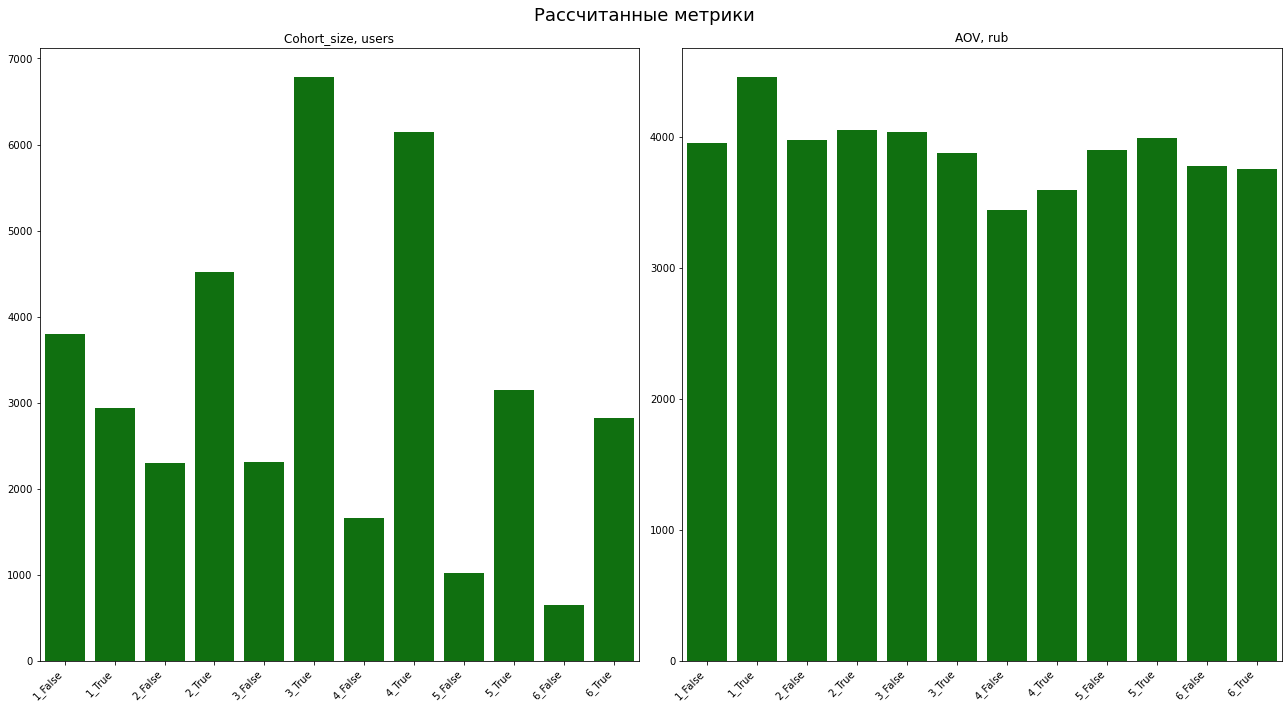

In [52]:
cohort_AOV_PP_plots(coh_month_promo)

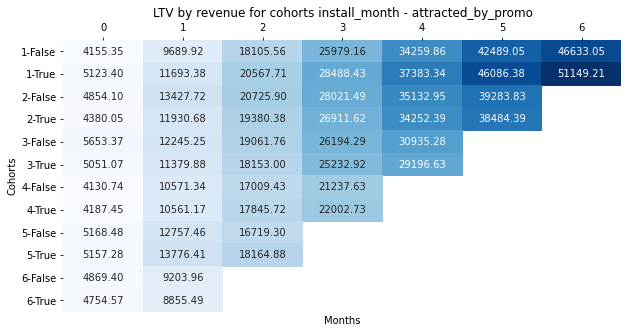

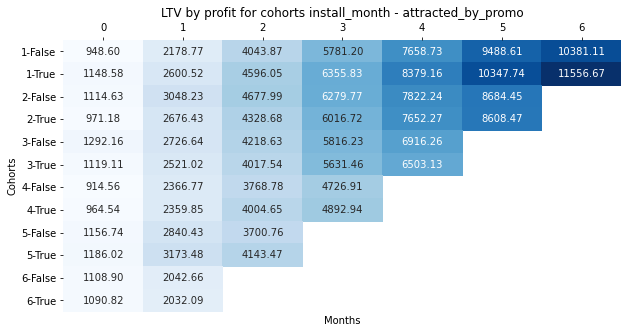

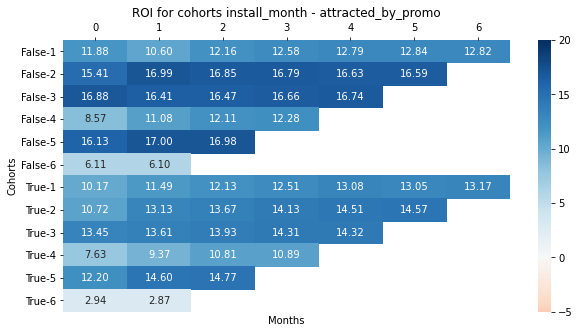

In [53]:
cohorts_LTV_ROI(df=cohort_data, criteria=['install_month', 'attracted_by_promo'])

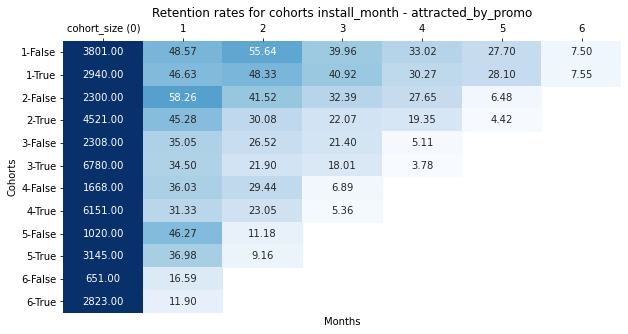

In [42]:
build_ret_rates(criteria=['install_month', 'attracted_by_promo'])

В целом LTV по прибыли выше для пользователей,  использовавших промокод, но не для всех месяцев (исключение – февральская и июньская пары когорт).
При этом использование промокода в целом негативно сказалось на ROI затрат.  
Хотя размер когорт для применивших промокод значительно выше (кроме января), отмечаем, что коэффициенты удержания в этой категории ниже.
Т.е. промокоды действительно помогли привлечь пользователей и повысить средний чек , однако пришедшие без их использования пользователи оказались более лояльны.
Самые высокие показатели демонстрируют январские и февральские когорты.

### Как скоро пользователь, пришедший с платного трафика, окупается? <a class="anchor" id="sixth-bullet"></a>
В целом - за 11 месяцев (для этого рассчитаем отношение затрат на медиаисточник к операционной прибыли)

In [55]:
full_costs_data = cohort_data[['sum', 'promo_costs', 'media_costs_per_order', 'delivery_costs', 'var_costs']] \
            .sum().to_frame().T
full_costs_data.media_costs_per_order / (full_costs_data['sum'] - (full_costs_data.var_costs
                                                                + full_costs_data.delivery_costs
                                                                + full_costs_data.promo_costs
                                                               )) / (185 / 365) * 12

0    11.028018
dtype: float64

###  Метрики по источникам установки <a class="anchor" id="seventh-bullet"></a>

In [60]:
coh_media = cohorts_AOV_PP(df=cohort_data, criteria=['media_source'])
coh_media.users.describe()

count     140.000000
mean      272.200000
std       521.948193
min         1.000000
25%        16.750000
50%        96.500000
75%       254.250000
max      3165.000000
Name: users, dtype: float64

In [61]:
# отфильтруем источники с количеством пользователей меньше медианного
coh_media[coh_media.users >= coh_media.users.median()] \
                    .sort_values(['PP']) \
                    .drop(columns=['media_source']) \
                    .style.bar(subset=['users', 'AOV', 'PP'], color='#91A5EB') \
                    .format(formatter={'AOV': "{:.1f}", 
                                       'PP': "{:.1f}"})

,cohort,users,AOV,PP
12,adtiming_int,3165,3972.4,4.5
100,qichengmedia_int,521,4308.5,6.0
55,infinity_int,182,4496.1,6.0
9,adsgreat_int,182,4127.0,6.2
68,mediasurfer_int,806,4186.9,6.4
24,bidmatrix_int,139,3777.3,6.4
47,gowithmedia_int,140,3885.4,7.2
87,munimob_int,1897,4192.0,7.4
135,yohoads_int,490,4489.4,7.5
112,sojoyapp_int,2554,4153.0,7.7


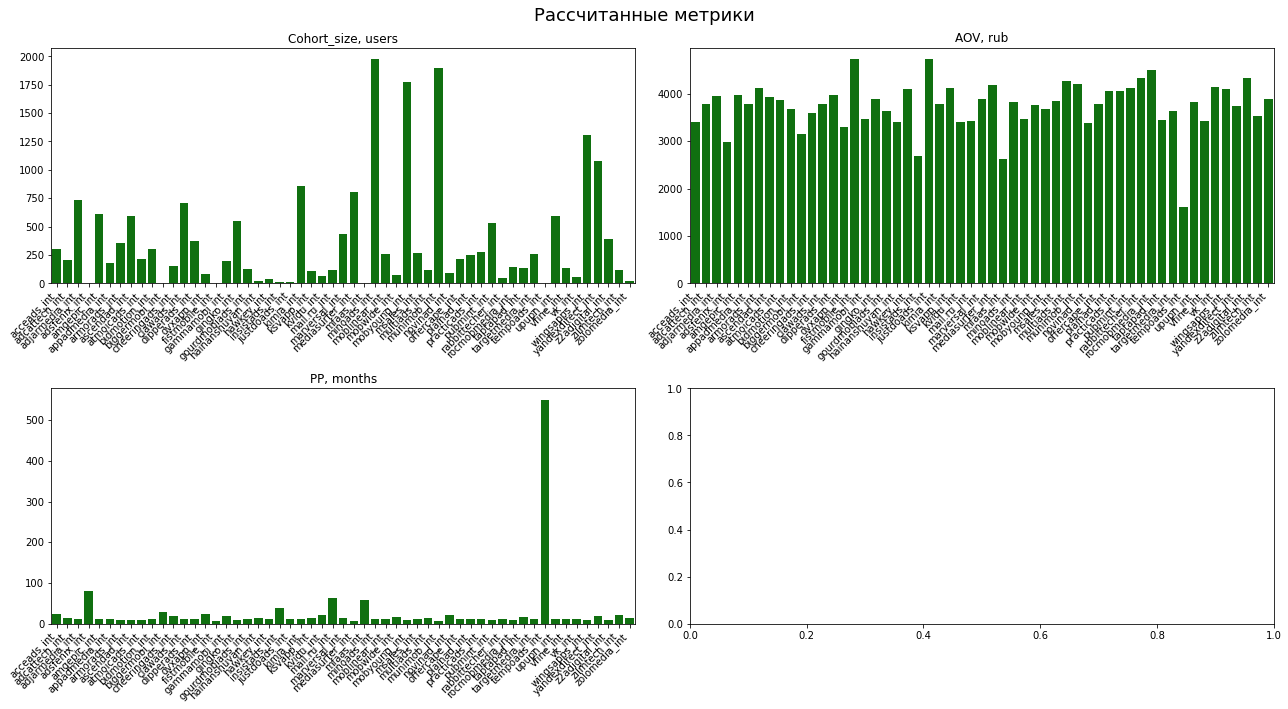

In [62]:
# графики только для источников, приводивших пользователей до конца периода
cohort_AOV_PP_plots(cohorts_AOV_PP(df=cohort_data_spec_sources, criteria=['media_source']))

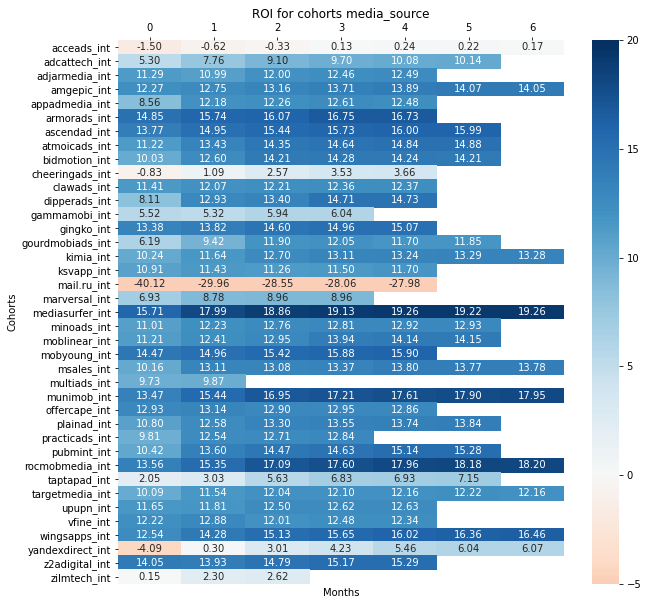

In [63]:
# источники, привлекающие пользователей до конца периода и размером когорт выше медианного
enough_size_resources_cohorts = coh_media[coh_media.users >= coh_media.users.median()] \
                                            .media_source.to_list()
cohorts_LTV_ROI(df=cohort_data_spec_sources.query('media_source in @enough_size_resources_cohorts'),
                criteria=['media_source'], figsize=(10, 10), metrics=['ROI'])

Среди источников, привлекающих пользователей до конца периода и количеством пользователей выше медианного, лучшая динамика  - у mediasurfer_int.